In [1]:
import dotenv
import os
import datetime as dt
import numpy as np
from scipy.stats import norm
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.data.historical.option import OptionHistoricalDataClient
from alpaca.data.requests import (StockLatestBarRequest,
                                  StockBarsRequest,
                                  OptionChainRequest,
                                  OptionBarsRequest)
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit

dotenv.load_dotenv()

True

In [2]:
def bs_dplus(spot, strike, maturity, carry, volatility):
    return (np.log(spot / strike) + (carry + (volatility**2)/2) * maturity) / (volatility * np.sqrt(maturity))

def bs_dminus(spot, strike, maturity, carry, volatility):
    return (np.log(spot / strike) + (carry - (volatility**2)/2) * maturity) / (volatility * np.sqrt(maturity))

def bs_price(cp, d_plus, d_minus, spot, strike, maturity, carry):
    if cp == "C":
        return norm.cdf(d_plus) * spot - norm.cdf(d_minus) * strike * np.exp(-carry*maturity)
    elif cp == "P":
        return norm.cdf(-d_minus) * strike * np.exp(-carry*maturity) - norm.cdf(-d_plus) * spot

def bs_delta(cp, d_plus):
    if cp == "C":
        return norm.cdf(d_plus)
    elif cp == "P":
        return norm.cdf(d_plus) - 1
    
def bs_gamma(d_plus, spot, maturity, volatility):
    return norm.pdf(d_plus) / (spot * volatility * np.sqrt(maturity))

def bs_vega(d_plus, spot, maturity):
    return spot * norm.pdf(d_plus) * np.sqrt(maturity) / 100

def bs_theta(cp, d_plus, d_minus, spot, strike, maturity, carry, volatility):
    if cp == "C":
        return -((spot*norm.pdf(d_plus)*volatility)/(2*np.sqrt(maturity)) - carry*strike*np.exp(-carry*maturity)*norm.cdf(d_minus)) / 365
    elif cp == "P":
        return -((spot*norm.pdf(d_plus)*volatility)/(2*np.sqrt(maturity)) + carry*strike*np.exp(-carry*maturity)*norm.cdf(-d_minus)) / 365

def bs_rho(cp, d_minus, strike, maturity, carry):
    if cp == "C":
        return strike * maturity * np.exp(-carry*maturity) * norm.cdf(d_minus) / 100
    if cp == "P":
        return -strike * maturity * np.exp(-carry*maturity) * norm.cdf(-d_minus) / 100
    
def bs_iv(market_price, cp, spot, strike, maturity, carry, tol=1e-4, max_iter=100000):
    vol = np.sqrt(2*np.pi/maturity) * market_price / spot
    for _ in range(max_iter):
        dplus = bs_dplus(spot, strike, maturity, carry, vol)
        dminus = dplus - vol * np.sqrt(maturity)
        price = bs_price(cp, dplus, dminus, spot, strike, maturity, carry)
        diff = price - market_price
        vega = bs_vega(dplus, spot, maturity) * 100

        if abs(diff) < tol:
            return vol
        if abs(vega) < 1e-10:
            return np.nan
        vol = vol - diff / vega

    return np.nan
    
    # vol_high = 3.0
    # vol_low = 0.01
    # for _ in range(max_iter):
    #     vol = (vol_high + vol_low) / 2
    #     dplus = bs_dplus(spot, strike, maturity, carry, vol)
    #     dminus = dplus - vol * np.sqrt(maturity)
    #     price = bs_price(cp, dplus, dminus, spot, strike, maturity, carry)
    #     diff = market_price - price

    #     if abs(diff) < tol:
    #         return vol
    #         vol_low = vol
    #     if diff > 0:
    #     else:
    #         vol_high = vol

    # return vol

In [3]:
class OptionQuote:
    def __init__(self,
                 contract: str,
                 cp: str,
                 strike: float,
                 bid: float,
                 ask: float,
                 mid: float,
                 iv: float,
                 delta: float,
                 gamma : float,
                 vega: float,
                 theta: float,
                 rho: float):
        self.contract = contract
        self.cp = cp
        self.strike = strike
        self.bid = bid
        self.ask = ask
        self.mid = mid
        self.iv = iv
        self.delta = delta
        self.gamma = gamma
        self.vega = vega
        self.theta = theta
        self.rho = rho

    def __repr__(self):
        return (
            f"<OptionQuote: {self.contract} | {self.cp} {self.strike}>\n"
            f"Bid: {self.bid}, Ask: {self.ask}, Mid: {self.mid:.2f}, IV: {self.iv:.4f}\n"
            f"Delta: {self.delta:.4f}, Gamma: {self.gamma:.4f}, Vega: {self.vega:.4f}, Theta: {self.theta:.4f}, Rho: {self.rho:.4f}\n"
        )
        

class OptionLink:
    def __init__(self, strike: float, gamma: float, vega: float, dplus: float, dminus: float):
        self.strike = strike
        self.gamma = gamma
        self.vega = vega
        self.dplus = dplus
        self.dminus = dminus
        self.C = None
        self.P = None

    def __getitem__(self, key):
        return getattr(self, key)
    
    def __setitem__(self, key, value):
        return setattr(self, key, value)
    
    def add_quote(self, cp: str, quote: OptionQuote):
        self[cp] = quote

    def __repr__(self):
        return (
            f"<OptionLink: {self.strike}>\n"
            f"Call: {self.C}"
            f"\n"
            f"Put: {self.P}"
            f"\n"
        )
    
    
class Chain(SortedDict):
    def __repr__(self):
        _links = [link.__repr__() for link in self.values()]
        return "\n".join(_links)


class OptionChain:
    def __init__(self, ticker: str, expiry: dt.datetime, maturity_t: float, spot: float, forward: float):
        self.chain = Chain()
        self.ticker = ticker
        self.expiry = expiry
        self.maturity_t = maturity_t
        self.maturity_d = maturity_t * 365
        self.spot = spot
        self.forward = forward
        self.carry = np.log(forward/spot) / maturity_t

    def load_chain(self, response_chain: dict):
        for _contract, _info in response_chain.items():
            _quote = _info.latest_quote
            _bid_price = _quote.bid_price
            _ask_price = _quote.ask_price
            if not _bid_price or not _ask_price:
                continue

            _cp = _contract[len(self.ticker)+6: len(self.ticker)+7]
            _strike = float(_contract[len(self.ticker)+7:]) / 1000
            _mid_price = (_quote.bid_price + _quote.ask_price) / 2
            _iv = bs_iv(_mid_price, _cp, self.spot, _strike, self.maturity_t, self.carry)
            if np.isnan(_iv):
                continue

            _dplus = bs_dplus(self.spot, _strike, self.maturity_t, self.carry, _iv)
            _dminus = bs_dminus(self.spot, _strike, self.maturity_t, self.carry, _iv)
            _delta = bs_delta(_cp, _dplus)
            _gamma = bs_gamma(_dplus, self.spot, self.maturity_t, _iv)
            _vega = bs_vega(_dplus, self.spot, self.maturity_t)
            _theta = bs_theta(_cp, _dplus, _dminus, self.spot, _strike, self.maturity_t, self.carry, _iv)
            _rho = bs_rho(_cp, _dminus, _strike, self.maturity_t, self.carry)

            _quote = OptionQuote(
                _contract,
                _cp,
                _strike,
                _bid_price,
                _ask_price,
                _mid_price,
                _iv,
                _delta,
                _gamma,
                _vega,
                _theta,
                _rho
            )

            self.chain.setdefault(_strike, OptionLink(_strike, _gamma, _vega, _dplus, _dminus))
            self.chain[_strike].add_quote(_cp, _quote)

    def contracts(self):
        _contracts = []
        for link in self.chain.values():
            if link.C:
                _contracts.append(link.C.contract)
            if link.P:
                _contracts.append(link.P.contract)

        return _contracts

### Inputs and Setup

In [4]:
APCA_API_KEY_ID = os.getenv("APCA-API-KEY-ID")
APCA_API_SECRET_KEY = os.getenv("APCA-API-SECRET-KEY")

stock_client = StockHistoricalDataClient(api_key=APCA_API_KEY_ID, secret_key=APCA_API_SECRET_KEY)
option_client = OptionHistoricalDataClient(api_key=APCA_API_KEY_ID, secret_key=APCA_API_SECRET_KEY)

In [5]:
ticker = "SPY"
expiry = "2025-06-20"
spot_overwrite = None

expiry_time = dt.time(20, 0, 0, tzinfo=dt.timezone.utc)
expiry_dt = dt.datetime.combine(dt.datetime.strptime(expiry, "%Y-%m-%d"), expiry_time)

stock_request = StockLatestBarRequest(symbol_or_symbols=ticker)
chain_request = OptionChainRequest(underlying_symbol=ticker, expiration_date=expiry)

### API Calls and Data Structuring

In [6]:
response_bars = stock_client.get_stock_latest_bar(stock_request)
if spot_overwrite:
    spot_price = spot_overwrite
else:
    spot_price = response_bars[ticker].close
current_dt = response_bars[ticker].timestamp
t_delta = expiry_dt - current_dt
maturity_t = (t_delta.days + t_delta.seconds / 86400) / 365

response_chain = option_client.get_option_chain(chain_request)

In [7]:
matching_dict = {}
smallest_diff = [np.inf, np.inf]
closest_strikes = [0, 0]
for contract, info in response_chain.items():
    _strike = float(contract[len(ticker)+7:]) / 1000
    _quote = info.latest_quote
    _type = contract[len(ticker)+6: len(ticker)+7]
    
    if _quote.ask_price and _quote.bid_price:
        _mid_price = (_quote.ask_price + _quote.bid_price) / 2
        if _strike in matching_dict:
            matching_dict[_strike][0 if _type == "C" else 1] = _mid_price
            matching_prices = matching_dict[_strike]
            diff = matching_prices[0] - matching_prices[1]
            if abs(diff) < abs(smallest_diff[0 if diff >= 0 else 1]):
                smallest_diff[0 if diff >= 0 else 1] = diff
                closest_strikes[0 if diff >= 0 else 1] = _strike
        else:
            matching_dict[_strike] = [0, 0]
            matching_dict[_strike][0 if _type == "C" else 1] = _mid_price
imp_forward = closest_strikes[0] - smallest_diff[0] * (closest_strikes[0] - closest_strikes[1]) / (smallest_diff[0] - smallest_diff[1])

option_chain = OptionChain(ticker, expiry_dt, maturity_t, spot_price, imp_forward)
option_chain.load_chain(response_chain)

### Skew Curve Building

In [8]:
option_strikes = list(option_chain.chain.keys())
forward_strike = min(option_strikes, key=lambda x: abs(x - imp_forward))
forward_iv = (option_chain.chain[forward_strike].C.iv + option_chain.chain[forward_strike].P.iv) / 2
core_prices = [imp_forward * np.exp((i-3) * forward_iv * maturity_t) for i in range(7)]
core_strikes = [min(option_strikes, key=lambda x: abs(x - price)) for price in core_prices]
grid_low = core_strikes[0]
grid_high = core_strikes[-1]

In [9]:
hist_spline = True
if hist_spline:
    start_date = (current_dt - dt.timedelta(weeks=2)).date().strftime("%Y-%m-%d")
    hist_stock_request = StockBarsRequest(symbol_or_symbols=ticker,
                                          timeframe=TimeFrame(1, TimeFrameUnit("Day")),
                                          start=start_date)                             # Taking data up to 2 weeks before
    hist_option_request = OptionBarsRequest(symbol_or_symbols=option_chain.contracts(),
                                     timeframe=TimeFrame(1, TimeFrameUnit("Day")),      
                                     start=start_date)                                  # Taking data up to 2 weeks before
    hist_stock_bars = stock_client.get_stock_bars(hist_stock_request).data[ticker]
    hist_option_bars = option_client.get_option_bars(hist_option_request).data    

In [10]:
snapshot = dt.date(2025, 4, 14)                             # Taking prices at the close

ss_maturity = (expiry_dt.date() - snapshot).days / 365

hist_spot = None
for hist_stock in hist_stock_bars:
    if hist_stock.timestamp.date() == snapshot:
        hist_spot = hist_stock.close
        break
if not hist_spot:
    raise Exception("Snapshot not a trading day")

snapshot_ivs = {}
for contract, hist_option in hist_option_bars.items():
    _strike = float(contract[len(ticker)+7:]) / 1000
    _type = contract[len(ticker)+6: len(ticker)+7]
    if _strike < grid_low or _strike > grid_high:
        continue

    for bar in hist_option:
        if bar.timestamp.date() == snapshot:
            _iv = bs_iv(bar.close, _type, hist_spot, _strike, ss_maturity, option_chain.carry)
            if np.isnan(_iv):
                continue
            snapshot_ivs[_strike] = _iv

In [11]:
grid_strikes = []
grid_ivs = []
core_ivs = []
for strike, link in option_chain.chain.items():
    if strike < grid_low or strike > grid_high:
        continue

    if strike in core_strikes:
        if link.C and link.P:
            core_ivs.append((link.C.iv + link.P.iv)/2)
        elif link.C:
            core_ivs.append(link.C.iv)
        else:
            core_ivs.append(link.P.iv)
    else:
        grid_strikes.append(strike)
        if link.C and link.P:
            grid_ivs.append((link.C.iv + link.P.iv)/2)
        elif link.C:
            grid_ivs.append(link.C.iv)
        else:
            grid_ivs.append(link.P.iv)

spline_coefs = np.polyfit(core_strikes, core_ivs, deg=5)
spline_func = np.poly1d(spline_coefs)
grid_range = np.linspace(grid_low, grid_high, int(grid_high - grid_low))
spline_y = spline_func(grid_range)

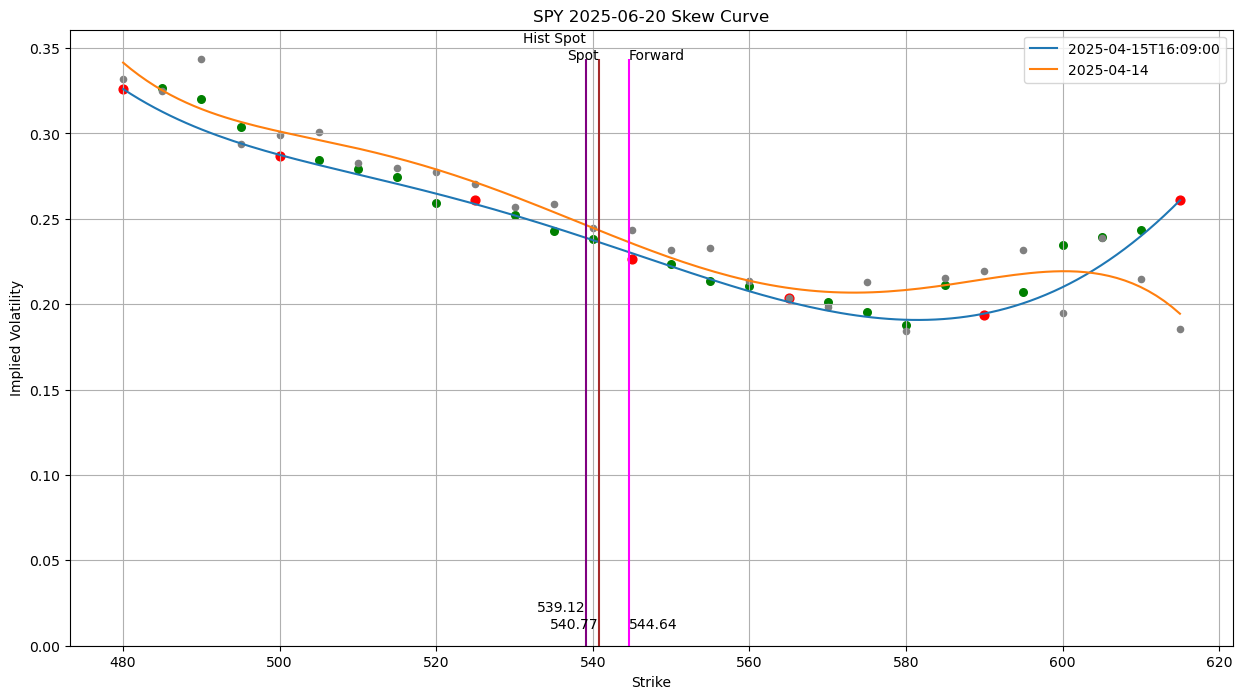

In [12]:
plt.figure(figsize=(15, 8))

skew_y_vals = core_ivs + grid_ivs + list(snapshot_ivs.values())
plt.scatter(core_strikes, core_ivs, color="red", s=40);
plt.scatter(grid_strikes, grid_ivs, color="green", s=30);
plt.plot(grid_range, spline_y, label=current_dt.strftime("%Y-%m-%dT%H:%M:%S"))
if hist_spline:
    hist_spline_coefs = np.polyfit(list(snapshot_ivs.keys()), list(snapshot_ivs.values()), deg=5)
    hist_spline_func = np.poly1d(hist_spline_coefs)
    hist_spline_y = hist_spline_func(grid_range)
    plt.scatter(snapshot_ivs.keys(), snapshot_ivs.values(), color="grey", s=20)
    plt.plot(grid_range, hist_spline_y, label=snapshot)
    plt.vlines([hist_spot], 0, max(skew_y_vals), colors=["purple", "grey"])
    plt.text(hist_spot, max(skew_y_vals)+0.01, "Hist Spot", ha="right")
    plt.text(hist_spot, 0.02, hist_spot, ha="right")
plt.vlines([spot_price, imp_forward], 0, max(skew_y_vals), colors=["brown", "magenta"])
plt.text(spot_price, max(skew_y_vals), "Spot", ha="right")
plt.text(spot_price, 0.01, spot_price, ha="right")
plt.text(imp_forward, max(skew_y_vals), "Forward", ha="left")
plt.text(imp_forward, 0.01, round(imp_forward, 2), ha="left")

plt.ylim(bottom=0);
plt.title(f"{ticker} {expiry} Skew Curve")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid()
plt.legend();

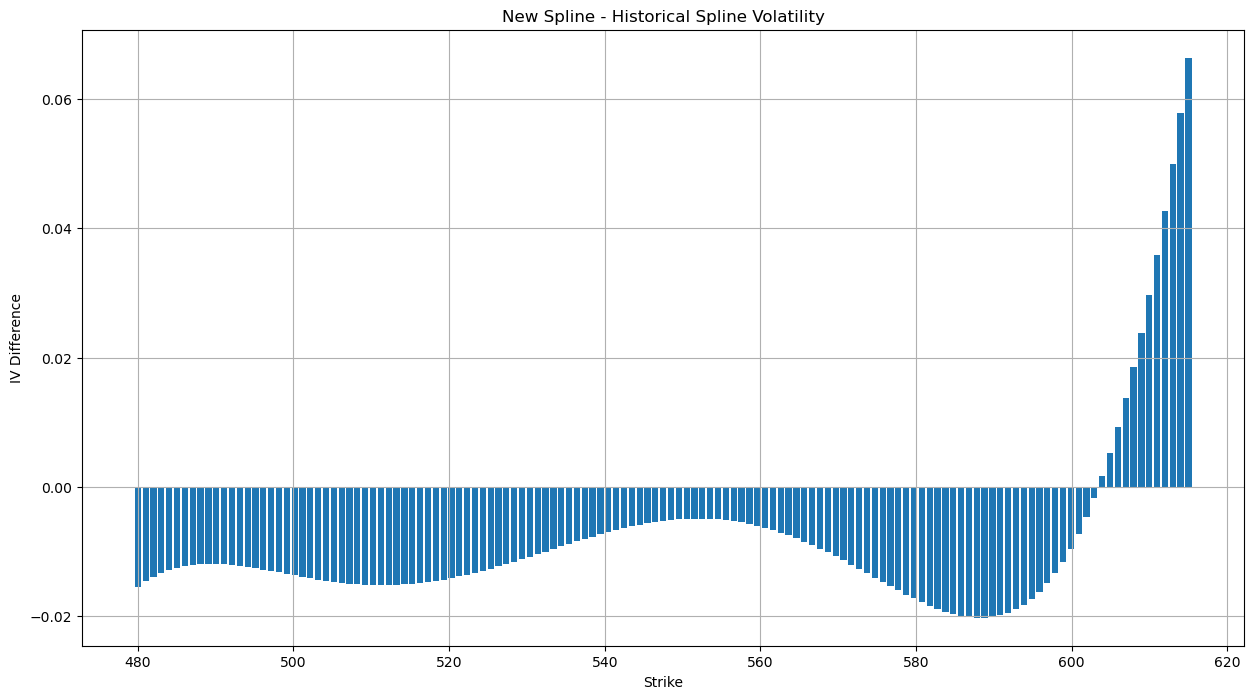

In [13]:
if hist_spline:
    vol_diff_y = [spline_func(x) - hist_spline_func(x) for x in grid_range]

    plt.figure(figsize=(15, 8))

    plt.bar(grid_range, vol_diff_y)

    plt.title("New Spline - Historical Spline Volatility")
    plt.xlabel("Strike")
    plt.ylabel("IV Difference")
    plt.grid()

### Implied Underlying Distribution

In [14]:
def flat_sheet_pdf(spot, strike, maturity, carry, volatility):
    return norm.pdf(-bs_dminus(spot, strike, maturity, carry, volatility))

flat_sheet_y = [flat_sheet_pdf(option_chain.spot,
                               x,
                               option_chain.maturity_t,
                               option_chain.carry,
                               forward_iv)
                               for x in grid_range]
flat_sheet_y /= np.trapezoid(flat_sheet_y, grid_range)

delta_k = grid_range[1] - grid_range[0]
C_strike, C_price = [], []
P_strike, P_price = [], []
for strike, link in option_chain.chain.items():
    if strike >= grid_low and strike <= grid_high:
        if link.C:
            C_strike.append(strike)
            C_price.append(link.C.mid)
        if link.P:
            P_strike.append(strike)
            P_price.append(link.P.mid)
C_spline_coefs = np.polyfit(C_strike, C_price, deg=5)
C_spline_func = np.poly1d(C_spline_coefs)
P_spline_coefs = np.polyfit(P_strike, P_price, deg=5)
P_spline_func = np.poly1d(P_spline_coefs)

implied_x = np.concatenate([[grid_range[0] - delta_k], grid_range, [grid_range[-1] + delta_k]])
implied_y = []
for i in range(1, len(grid_range)+1):
    _strike = implied_x[i]
    implied_prob = 0
    options_used = 0
    if _strike >= C_strike[0] and _strike <= C_strike[-1]:
        options_used += 1
        implied_prob += (
            np.exp(option_chain.carry*option_chain.maturity_t) * 
            ((C_spline_func(implied_x[i-1]) - 2*C_spline_func(_strike) + C_spline_func(implied_x[i+1])) / (delta_k**2))
        )
    if _strike >= P_strike[0] and _strike <= P_strike[-1]:
        options_used += 1
        implied_prob += (
            np.exp(option_chain.carry*option_chain.maturity_t) * 
            ((P_spline_func(implied_x[i-1]) - 2*P_spline_func(_strike) + P_spline_func(implied_x[i+1])) / (delta_k**2))
        )
    implied_y.append(implied_prob/options_used)

smooth_coefs = np.polyfit(grid_range, implied_y, deg=int(len(implied_y)**0.4))
smooth_func = np.poly1d(smooth_coefs)
implied_y = smooth_func(grid_range)
implied_y = np.maximum(0, implied_y)
implied_y /= np.trapezoid(implied_y, grid_range)

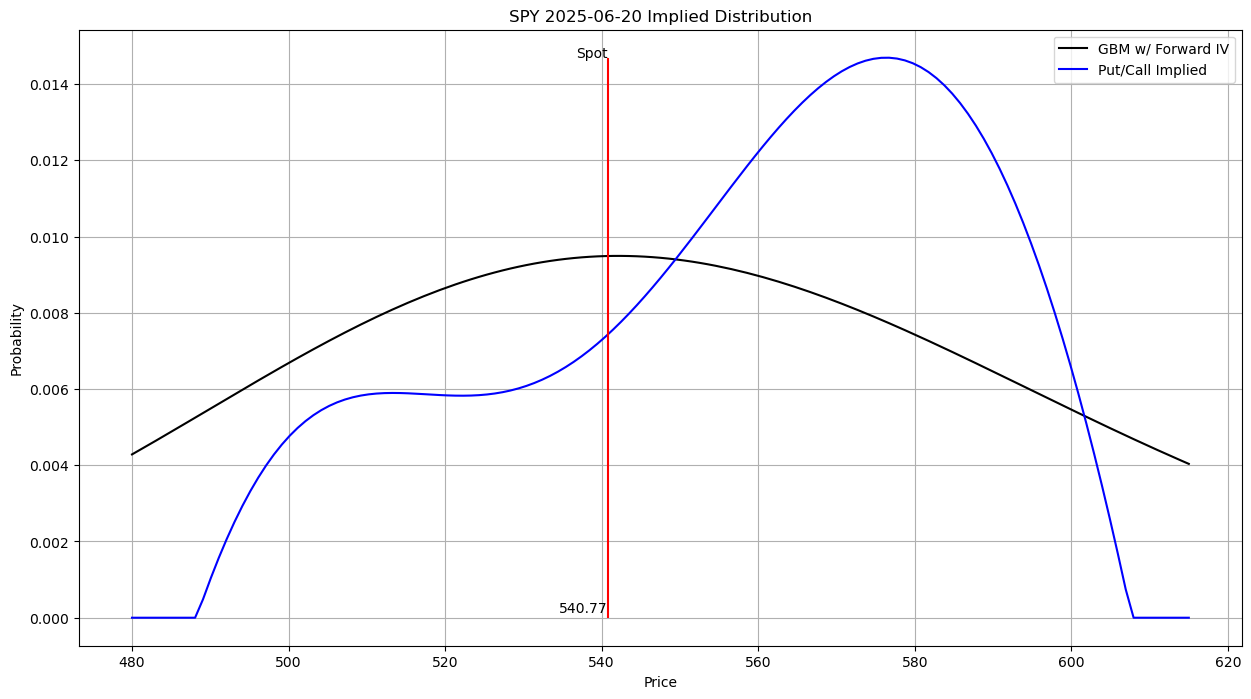

In [15]:
plt.figure(figsize=(15, 8))

implied_y_vals = np.concatenate([flat_sheet_y, implied_y])
plt.plot(grid_range, flat_sheet_y, color="black", label="GBM w/ Forward IV");
plt.plot(grid_range, implied_y, color="blue", label="Put/Call Implied")
plt.vlines([option_chain.spot], 0, max(implied_y_vals), colors="red")
plt.text(option_chain.spot, max(implied_y_vals), "Spot", ha="right")
plt.text(option_chain.spot, max(implied_y_vals)*0.01, option_chain.spot, ha="right")

plt.title(f"{ticker} {expiry} Implied Distribution")
plt.xlabel("Price")
plt.ylabel("Probability")
plt.legend()
plt.grid()